In [59]:
# Import Packages


# For Data Preparation
import tensorflow as tf
import numpy as np
import pandas as pd
import re # regular expressions


# For Word Embedding
import nltk.data
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')
from collections import Counter
import gensim
import gensim.models as g
from gensim.models import Word2Vec
from gensim.models import Phrases

import logging
#import visword2vec as vv

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
#from matplotlib import pyplot

from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression


# For LSTM Model
from tensorflow.contrib import rnn
import pprint

pp = pprint.PrettyPrinter(indent=4)
sess = tf.InteractiveSession()
tf.set_random_seed(777)  # reproducibility

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional,Dropout, Input, SpatialDropout1D, CuDNNLSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences




[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/eunbeejang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eunbeejang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# Data Preparation

In [60]:
# Data Processing

'''
#Read File
with open('FILE NAME', 'r') as f:
    bias_data = f.read()
'''

# Names for the columns (Header)
#cols = ['sentence', 'bias', 'sex', 'age', 'occupation', 'citizenship']

# Load the data from a CSV (returns type(dataframe))
bias_data = pd.read_csv('./scrapeBIG2.csv', sep=',',  encoding='latin-1') # encoding='latin-1', names=cols, header=None,
print("Data loaded")


# Randomize data
bias_data = bias_data.reindex(np.random.permutation(bias_data.index))

# Replace NAN with Zero(0)
bias_data.fillna(0, inplace=True)



print(len(bias_data))


"""
# Accessing the data
bias_data.value
bias_data[rows:cols]

# Basic Stats about the data
bias_data.describe()
bias_data.count
"""

Data loaded
1614


'\n# Accessing the data\nbias_data.value\nbias_data[rows:cols]\n\n# Basic Stats about the data\nbias_data.describe()\nbias_data.count\n'

In [61]:



bias_data[:10]




,Sentence,Bias,Random,Sex,Age,Occupation,Citizenship
1241,"When I'm training and competing, I don't care ...",1,0.446231,0.0,0.0,0.0,0.0
1531,When politicians get even just a dozen letters...,0,0.176577,0.0,0.0,0.0,0.0
1317,The sad truth is that it simply isnÛªt.,0,0.404230,0.0,0.0,0.0,0.0
224,I think ballet can be the perfect environment ...,1,0.965305,0.0,0.0,0.0,0.0
915,The statistics for sexual assault in prisons a...,0,0.779790,0.0,0.0,0.0,0.0
169,"It puts me at peace; when I'm playing well, ma...",1,0.540774,0.0,0.0,0.0,0.0
1228,The men's attorney didn't respond to requests ...,0,0.338805,0.0,0.0,0.0,0.0
792,You explored her body whenever you were alone.,0,0.476792,0.0,0.0,0.0,0.0
182,As a woman in tech who has been called all of ...,0,0.500241,0.0,0.0,0.0,0.0
1520,"And putting aside the Bundy extreme, itÛªs re...",0,0.904495,0.0,0.0,0.0,0.0


In [62]:
sentence = bias_data['Sentence']
label = bias_data['Bias']

print(type(sentence))
print(type(label))
#weight = bias_data['Weight']

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [63]:
#print(sentence)
#print(label)
print(sentence[0])


If you had a man's genitals you were assigned to a men's prison.


In [64]:
# Convert a sentence into a list of words

def sentence_to_wordlist(sentence, remove_stopwords=False):
    # 1. Remove non-letters
    sentence_text = re.sub(r'[^\w\s]','', sentence)
    # 2. Convert words to lower case and split them
    words = sentence_text.lower().split()
    # 3. Stemming
    words = [stemmer.stem(w) for w in words] 
    # 4. Lemmatizing
    words = [lemmatizer.lemmatize(word) for word in words]
    # 5. Return a list of words
    return(words)

In [65]:
sentence_to_wordlist(sentence[0])

['if',
 'you',
 'had',
 'a',
 'man',
 'genit',
 'you',
 'were',
 'assign',
 'to',
 'a',
 'men',
 'prison']

In [66]:
# List of sentences where each sentence is a list of words
def data_to_sentences(data, tokenizer, remove_stopwords=False ):
    try:
        # 1. Use the NLTK tokenizer to split the text into sentences
        raw_sentences = tokenizer.tokenize(data.strip())
        # 2. Loop over each sentence
        sentences = []
        for raw_sentence in raw_sentences:
            # If a sentence is empty, skip it
            if len(raw_sentence) > 0:
                # Otherwise, call sentence_to_wordlist to get a list of words
                sentences.append(sentence_to_wordlist(raw_sentence))
        # 3. Return the list of sentences (each sentence is a list of words, so this returns a list of lists)
        len(sentences)
        #print('GOOD')
        return sentences
    except:
        print('ERROR :', data)

In [67]:
def list_of_sentences(data):
    sentences = []
    for i in data:
        sentences.append(sentence_to_wordlist(i))
    return sentences

In [68]:
print(type(sentence))

<class 'pandas.core.series.Series'>


In [69]:
#sentence = bias_data['sentence'].tolist()

sentences = []

for i in range(len(sentence)):
    # Replace all the numbers with ### -- this will remove all the numbers from the sentence
    #data = re.sub("\d", "####", sentence[i]) 
    # data = sentence[i].replace(/[0-9]+/g, '###')
    sentences += data_to_sentences(sentence[i], tokenizer)

print("There are " + str(len(sentences)) + " sentences in the corpus of bias_data.")
              
# Accessing each sentences
# sentences[index]

There are 1626 sentences in the corpus of bias_data.


In [70]:
sentences = list_of_sentences(bias_data['Sentence'])
labels = bias_data['Bias'].tolist()

print(len(labels))
print(len(sentence))
print(len(sentences))
print(len(bias_data))
sentences

1614
1614
1614
1614


[['when',
  'im',
  'train',
  'and',
  'compet',
  'i',
  'dont',
  'care',
  'about',
  'the',
  'way',
  'i',
  'look'],
 ['when',
  'politician',
  'get',
  'even',
  'just',
  'a',
  'dozen',
  'letter',
  'about',
  'an',
  'issu',
  'trust',
  'me',
  'they',
  'notic'],
 ['the', 'sad', 'truth', 'is', 'that', 'it', 'simpli', 'isnûªt'],
 ['i',
  'think',
  'ballet',
  'can',
  'be',
  'the',
  'perfect',
  'environ',
  'for',
  'gender',
  'fluiditi',
  'm',
  'rojo',
  'said'],
 ['the',
  'statist',
  'for',
  'sexual',
  'assault',
  'in',
  'prison',
  'and',
  'jail',
  'are',
  'dismal'],
 ['it',
  'put',
  'me',
  'at',
  'peac',
  'when',
  'im',
  'play',
  'well',
  'mayb',
  'ill',
  'hit',
  'a',
  'coupl',
  'bad',
  'shot',
  'but',
  'i',
  'can',
  'bounc',
  'back',
  'and',
  'you',
  'have',
  'some',
  'good',
  'stuff',
  'fresh',
  'in',
  'your',
  'memori',
  'to',
  'go',
  'to',
  'if',
  'your',
  'in',
  'a',
  'tough',
  'spot',
  'and',
  'you',
  'ca

# Word Embedding

In [71]:
# Create Word Vectors

# train model
model = Word2Vec(sentences, min_count=1)

# Calling init_sims will make the model will be better for memory if we don't want to train the model over and over again
model.init_sims(replace=True)

# Summarize the loaded model

# Summarize vocabulary
words = list(model.wv.vocab)
n_words = print(len(words))



word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

# save model
model.save('model.bin')

# load model
new_model = Word2Vec.load('model.bin')

# access vector for one word
#print(model['sentence'])



3979
Number of word vectors: 3979


/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


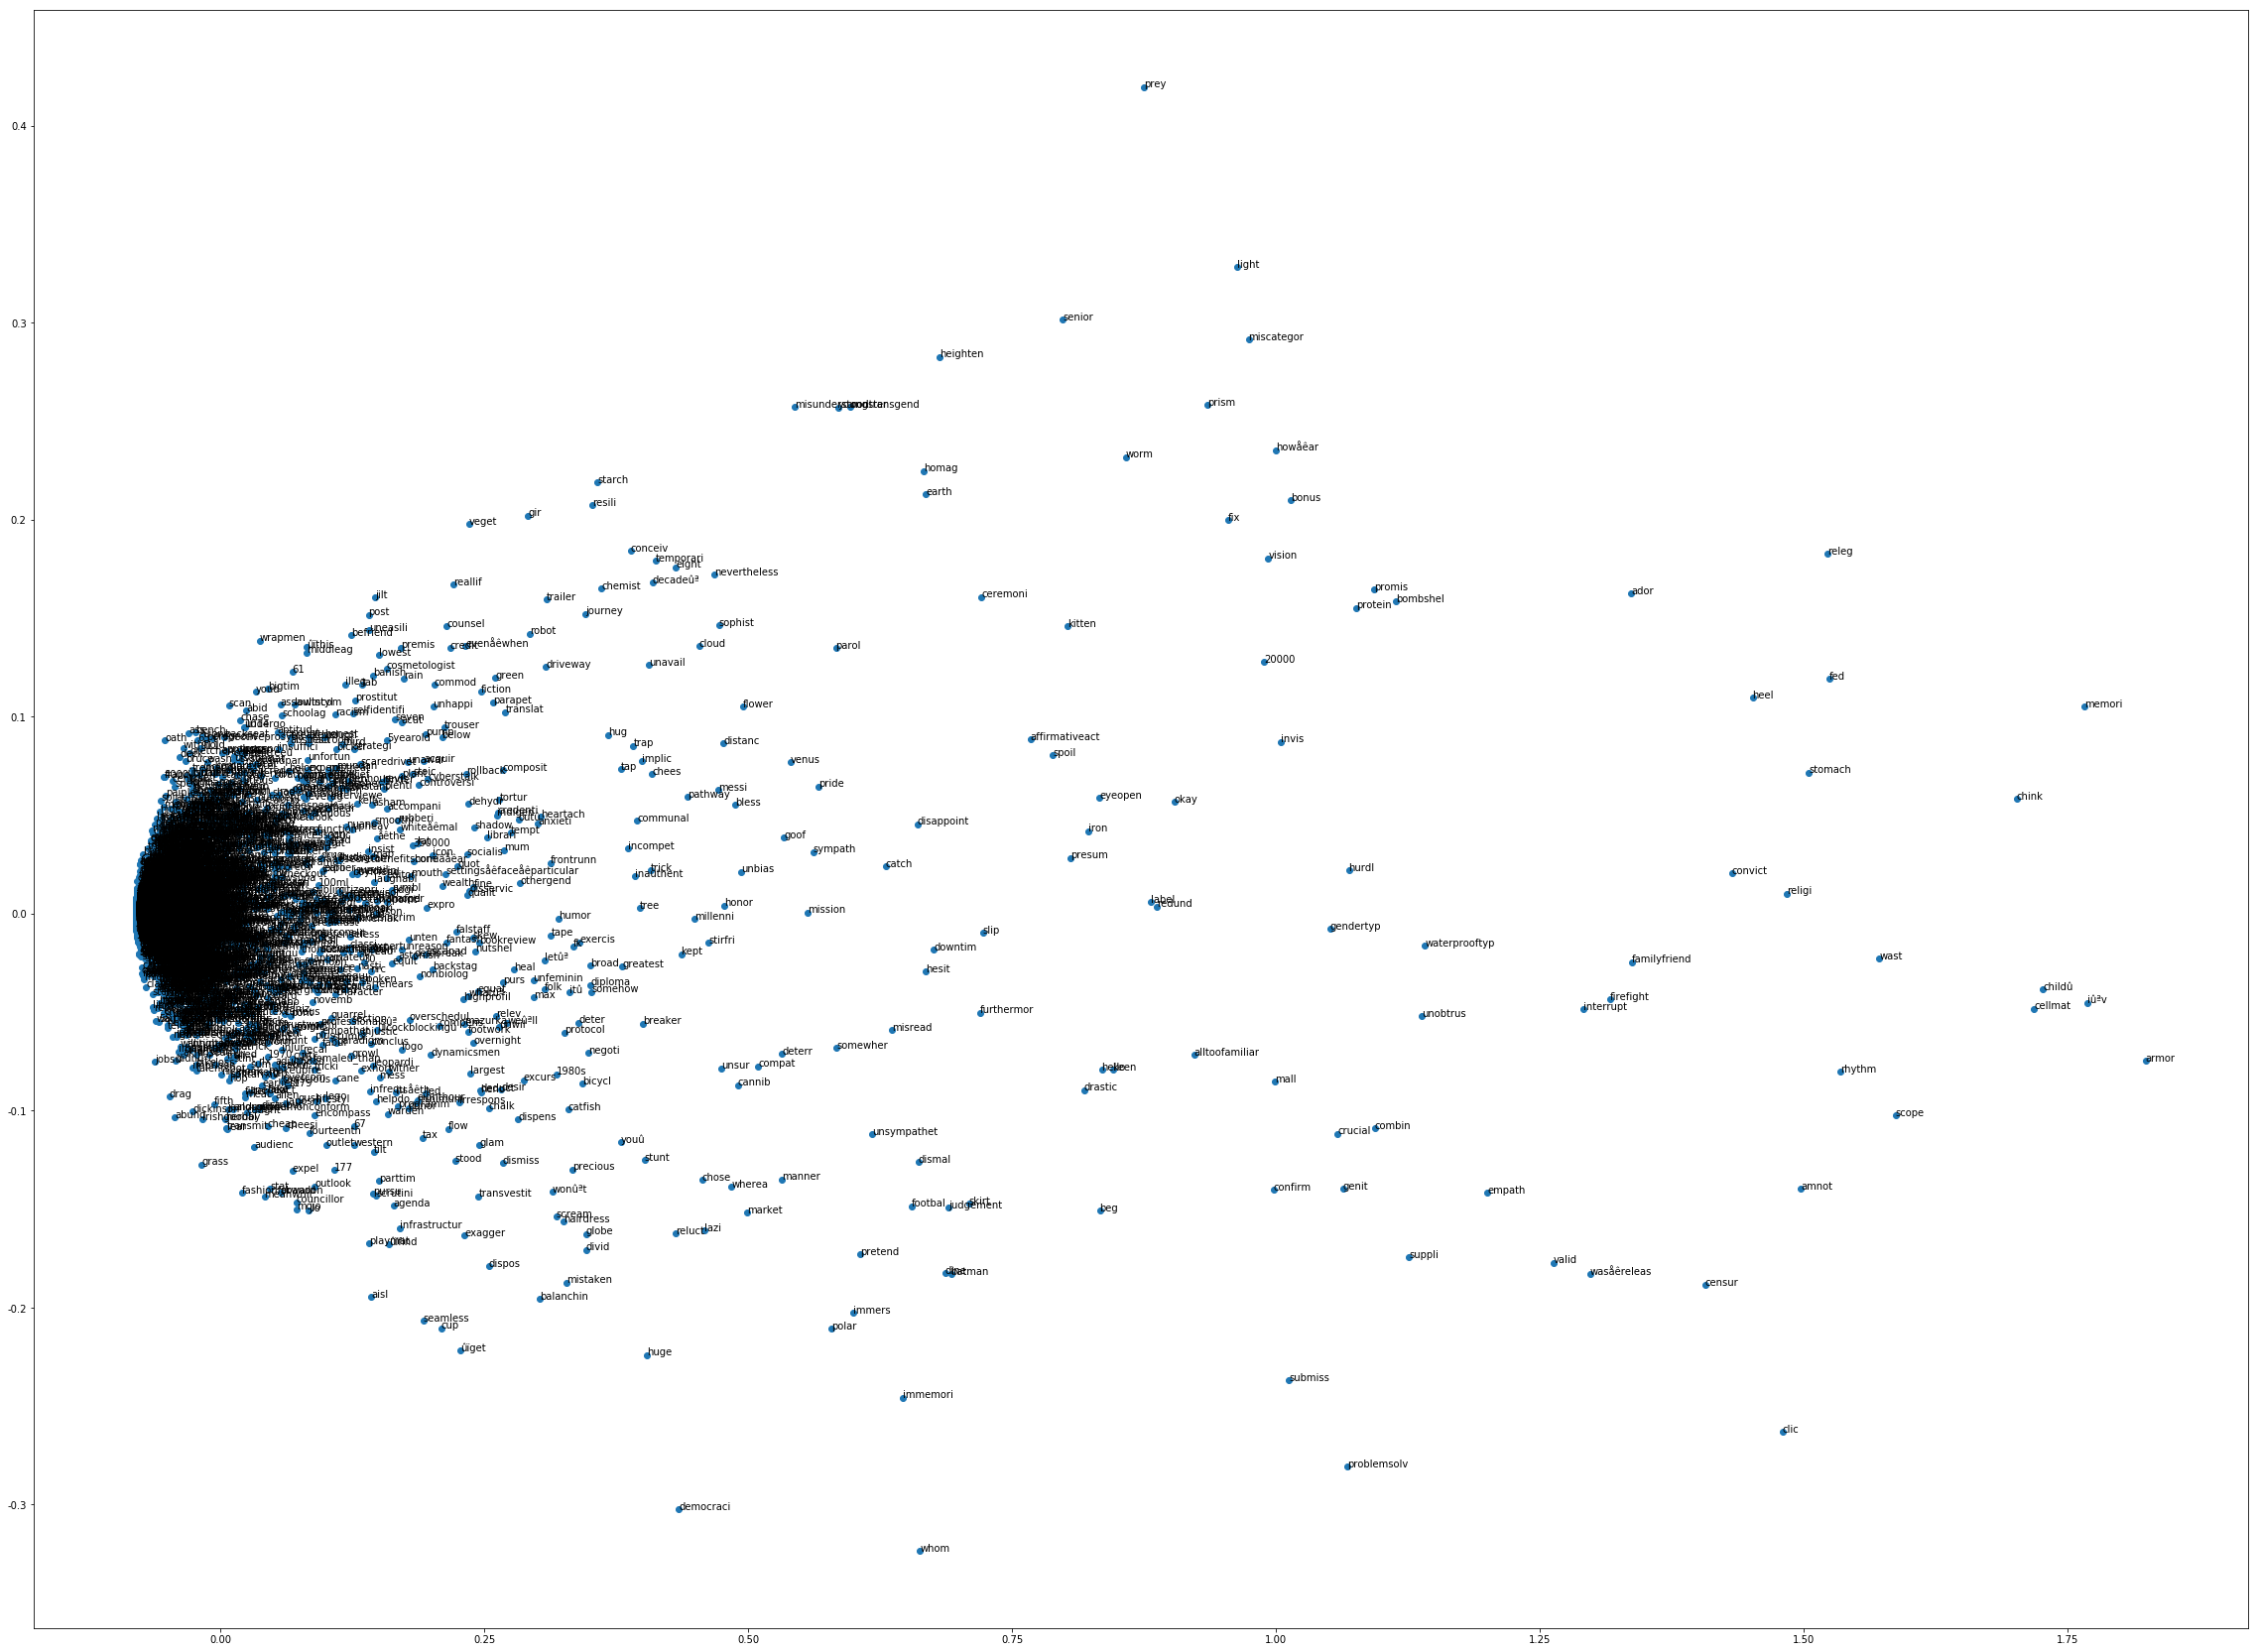

In [72]:

# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.figure(figsize=(40,30))
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()


In [73]:
# Visualize word2vec with t-SNE

# Deal with font errors
mpl.rcParams['axes.unicode_minus'] = False

this_model = g.Doc2Vec.load('model.bin')
this_vocab = list(this_model.wv.vocab)
X = this_model[this_vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components = 2)

# Vector only 100 words
X_tsne = tsne.fit_transform(X[:50,:])

df = pd.DataFrame(X_tsne, index=this_vocab[:50], columns=['x','y'])
df.shape

df.head(10)

/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


3979
[ 0.07823024  0.06400032  0.01185033 -0.13994499  0.1734971  -0.01879969
 -0.04157582 -0.01367298  0.08279179 -0.05386298]


,x,y
when,-22.441816,16.572287
im,-42.189632,-129.266937
train,56.970051,-139.085953
and,-85.987946,5.124521
compet,-144.184723,121.227974
i,78.049896,32.073189
dont,99.439934,-7.880548
care,-132.859299,-7.971902
about,22.959188,-23.685379
the,-91.774071,45.279671


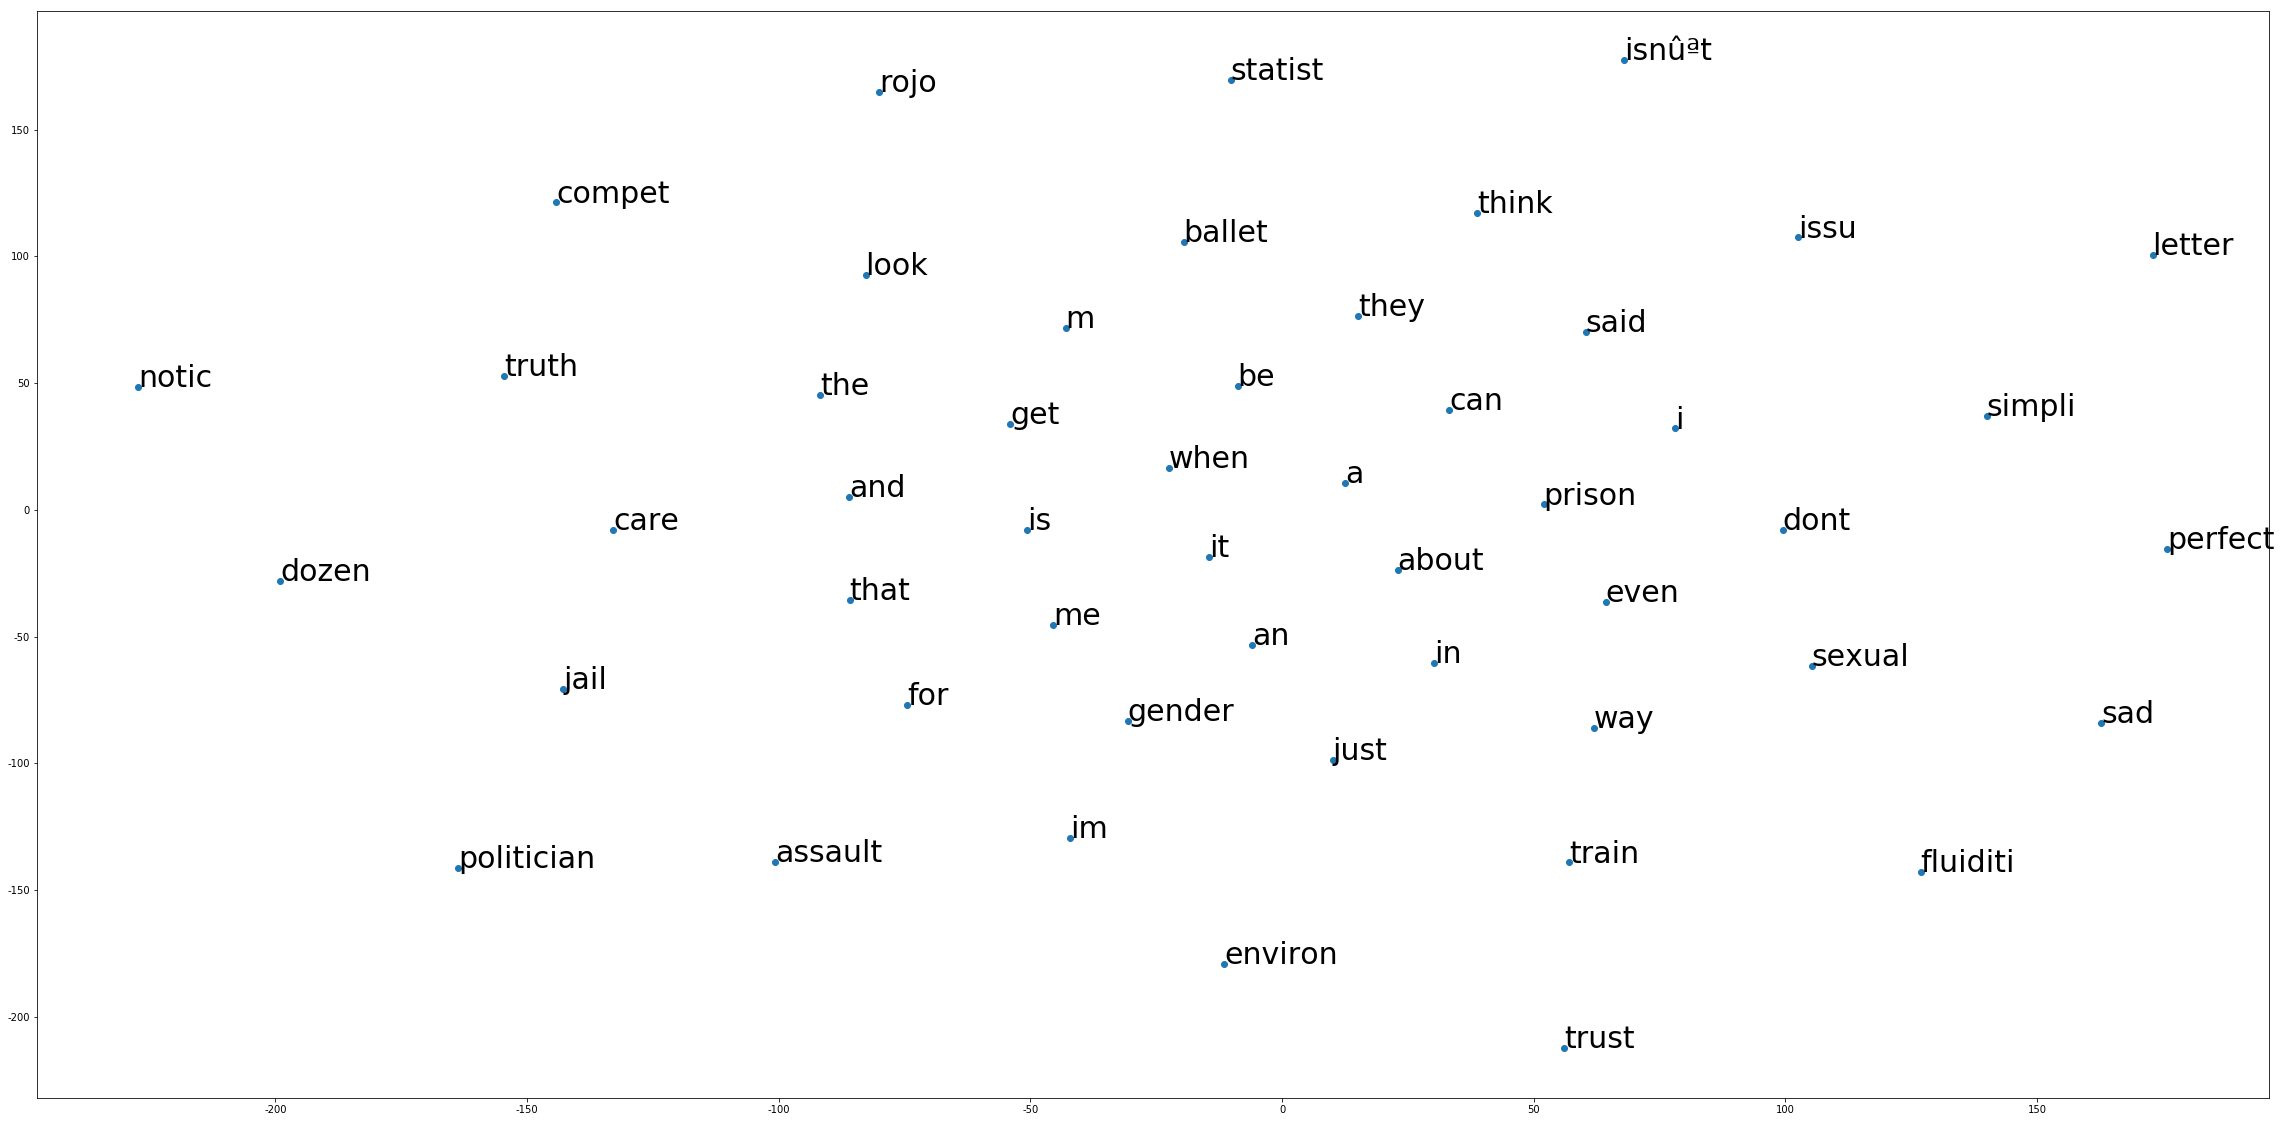

In [74]:
# Plot using TSNE
fig = plt.figure()
fig.set_size_inches(40,20)
ax = fig.add_subplot(1,1,1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()

In [75]:
model.wv.most_similar("leadership")


[('her', 0.9989177584648132),
 ('chang', 0.998917281627655),
 ('i', 0.9989097714424133),
 ('when', 0.9989036321640015),
 ('look', 0.9988990426063538),
 ('with', 0.9988895058631897),
 ('that', 0.9988844394683838),
 ('my', 0.9988768100738525),
 ('for', 0.99887615442276),
 ('those', 0.998874306678772)]

In [76]:
###################################### DON'T NEED THIS
###################################### IGNORE THIS CELL
# sentence_index = (example) sentence[0]

"""
def sentence_to_vector(sentence_index):
    each_sentence = sentence_to_wordlist(sentence_index)
    each_sentence_vector = []
    for word in each_sentence:
        ##### ASK ANDRE:  Should the sentence be a list or a numpy array??
        each_sentence_vector.append([model[word]])
    each_sentence_vector = np.asarray(each_sentence_vector)
    #print(type(each_sentence_vector)) # Check the type of the sentence vector
    #print(each_sentence_vector.shape) # Check the shape of the sentence vector
    return each_sentence_vector
"""

'\ndef sentence_to_vector(sentence_index):\n    each_sentence = sentence_to_wordlist(sentence_index)\n    each_sentence_vector = []\n    for word in each_sentence:\n        ##### ASK ANDRE:  Should the sentence be a list or a numpy array??\n        each_sentence_vector.append([model[word]])\n    each_sentence_vector = np.asarray(each_sentence_vector)\n    #print(type(each_sentence_vector)) # Check the type of the sentence vector\n    #print(each_sentence_vector.shape) # Check the shape of the sentence vector\n    return each_sentence_vector\n'

In [77]:
print(type(words))

<class 'list'>


In [78]:
# Build dictionary & inv_vocab
def create_vocab(data_collect, max_vocab):
    """ Create a dictionary of words to int, and the reverse

    You'll want to save this, required for model restore
    """
    # Get raw data
    # x_list = [data.x for data in data_collect.values()]
    x_list = data_collect
    sample_count = sum([len(x) for x in x_list])
    words = []
    for data in x_list:
      words.extend([data])
   # words.extend([self.eos_tag] * sample_count) # silly hack to add tag
    count = Counter(words) # word count
#    print('@@ The words[] is : ', words)
#    print('@@ The count is : ', count)
    # Vocab in descending order
    inv_vocab = [x[0] for x in count.most_common(max_vocab)]
#    print('@@ inv_vocab is : ', inv_vocab)
   # if self.unknown_tag:
   #   inv_vocab.insert(0, self.unknown_tag)
    # Vocab with index position instead of word
    vocab = {x: i for i, x in enumerate(inv_vocab, 1)}
    return vocab, inv_vocab

In [79]:
vocab, inv_vocab = create_vocab(words, len(words))
print(type(vocab), type(inv_vocab))
#print(vocab)
print(vocab)

inv_vocab.index('imagin')



<class 'dict'> <class 'list'>
{'when': 1, 'im': 2, 'train': 3, 'and': 4, 'compet': 5, 'i': 6, 'dont': 7, 'care': 8, 'about': 9, 'the': 10, 'way': 11, 'look': 12, 'politician': 13, 'get': 14, 'even': 15, 'just': 16, 'a': 17, 'dozen': 18, 'letter': 19, 'an': 20, 'issu': 21, 'trust': 22, 'me': 23, 'they': 24, 'notic': 25, 'sad': 26, 'truth': 27, 'is': 28, 'that': 29, 'it': 30, 'simpli': 31, 'isnûªt': 32, 'think': 33, 'ballet': 34, 'can': 35, 'be': 36, 'perfect': 37, 'environ': 38, 'for': 39, 'gender': 40, 'fluiditi': 41, 'm': 42, 'rojo': 43, 'said': 44, 'statist': 45, 'sexual': 46, 'assault': 47, 'in': 48, 'prison': 49, 'jail': 50, 'are': 51, 'dismal': 52, 'put': 53, 'at': 54, 'peac': 55, 'play': 56, 'well': 57, 'mayb': 58, 'ill': 59, 'hit': 60, 'coupl': 61, 'bad': 62, 'shot': 63, 'but': 64, 'bounc': 65, 'back': 66, 'you': 67, 'have': 68, 'some': 69, 'good': 70, 'stuff': 71, 'fresh': 72, 'your': 73, 'memori': 74, 'to': 75, 'go': 76, 'if': 77, 'tough': 78, 'spot': 79, 'stay': 80, 'on': 81,

1371

In [80]:
def find_max_length_sentence(sentence):
    max_length = 0
    for i in sentence:
        length = len(sentence_to_wordlist(i))
        if max_length < length:
            max_length = length
    return max_length

In [81]:
seq_length = find_max_length_sentence(sentence)
print(seq_length)

75


In [82]:
# Map each word to corresponding vector
def map_to_vec(word):
    vec = model[word]
    return vec

map_to_vec('care')

/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 0.07722617,  0.06496917,  0.01514051, -0.13812275,  0.17537993,
       -0.01642949, -0.0447946 , -0.01671954,  0.08397841, -0.0517021 ,
       -0.10497472, -0.08710764, -0.02205281,  0.02973241,  0.11698778,
        0.0011648 ,  0.20097594,  0.12622151, -0.02542379,  0.13296553,
        0.11711232, -0.05057906,  0.06088156,  0.03620951, -0.13181907,
        0.08732894, -0.03021114, -0.02999889,  0.0199671 ,  0.00054466,
        0.12635514,  0.14550985,  0.09677254, -0.00562494,  0.17826566,
       -0.24228513, -0.05030836, -0.1953411 , -0.11377048, -0.11562689,
        0.02973596, -0.01681772, -0.01130759, -0.13574861, -0.09944136,
        0.06251584, -0.06753764, -0.13830873,  0.04244655, -0.06059556,
        0.22396557,  0.02293341,  0.05099634, -0.02551854, -0.08756969,
       -0.05155375,  0.01711991,  0.07972583,  0.06238559, -0.01827698,
        0.06051961, -0.00531288,  0.05893382,  0.04296521,  0.10952504,
       -0.06136328, -0.04192938,  0.20898297, -0.13868329, -0.15

In [83]:
# Embedding Matrix
#emb_matrix = np.zeros(shape = (len(words),100))
def make_emb_matrix(inv_vocab):
    emb_matrix = []
    for word in inv_vocab:
        emb_matrix.append(map_to_vec(word))
    return emb_matrix


embedding = np.asarray(make_emb_matrix(inv_vocab))
print(embedding)


[[ 0.07823024  0.06400032  0.01185033 ...,  0.03296454 -0.10985956
  -0.06597687]
 [ 0.07705881  0.06263573  0.00905356 ...,  0.03565876 -0.10415874
  -0.0641037 ]
 [ 0.08106971  0.05913516  0.01059784 ...,  0.02975578 -0.10860582
  -0.07069767]
 ..., 
 [ 0.10570881  0.00927645  0.03467765 ...,  0.02834379 -0.08375936
  -0.05309375]
 [ 0.05546922  0.06535858  0.01078729 ..., -0.00698166 -0.12685342
  -0.0863511 ]
 [ 0.08279312  0.0697848   0.00387883 ...,  0.06686014 -0.10177594
  -0.11203347]]


/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [84]:

int_sentences = np.zeros(shape = (len(sentences),seq_length))
test = np.ones(shape = (1, 2))
int_sentences[0][0:len(word)] = inv_vocab.index(word)

int_sentences[0]

inv_vocab.index('care')


7

In [85]:

## Batch of integers (matrix of sentences where each word is represented as int)
#emb_matrix = np.zeros(shape = (len(words),100))


def integerize_sentences(sentences):
    int_sentences = np.zeros(shape = (len(sentences),seq_length), dtype=np.int16)
    i = 0
    for sentence in sentences:
        int_sentence = np.empty((1,0))
        for word in sentence:
            int_sentence = np.append(int_sentence, inv_vocab.index(word))
        int_sentences[i][0:len(sentence)] = int_sentence
        i += 1
    return int_sentences

sentence_matrix = integerize_sentences(sentences)

print(sentence_matrix[1500])

print(type(sentence_matrix))


# Convert numpy array to list
#sentence_matrix = sentence_matrix.tolist()
#print(type(sentence_matrix))
#sentence_matrix[1500]


[  13  154   94 1234  647  101  701  303  456  242    3  396  463  154  951
  101    9  323   23  988    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
<class 'numpy.ndarray'>


In [86]:
print(type(sentences))

<class 'list'>


In [87]:
print(sentences)

[['when', 'im', 'train', 'and', 'compet', 'i', 'dont', 'care', 'about', 'the', 'way', 'i', 'look'], ['when', 'politician', 'get', 'even', 'just', 'a', 'dozen', 'letter', 'about', 'an', 'issu', 'trust', 'me', 'they', 'notic'], ['the', 'sad', 'truth', 'is', 'that', 'it', 'simpli', 'isnûªt'], ['i', 'think', 'ballet', 'can', 'be', 'the', 'perfect', 'environ', 'for', 'gender', 'fluiditi', 'm', 'rojo', 'said'], ['the', 'statist', 'for', 'sexual', 'assault', 'in', 'prison', 'and', 'jail', 'are', 'dismal'], ['it', 'put', 'me', 'at', 'peac', 'when', 'im', 'play', 'well', 'mayb', 'ill', 'hit', 'a', 'coupl', 'bad', 'shot', 'but', 'i', 'can', 'bounc', 'back', 'and', 'you', 'have', 'some', 'good', 'stuff', 'fresh', 'in', 'your', 'memori', 'to', 'go', 'to', 'if', 'your', 'in', 'a', 'tough', 'spot', 'and', 'you', 'can', 'stay', 'on', 'track'], ['the', 'men', 'attorney', 'didnt', 'respond', 'to', 'request', 'for', 'comment'], ['you', 'explor', 'her', 'bodi', 'whenev', 'you', 'were', 'alon'], ['a', 'a'

# Training, Validation, Test dataset

In [88]:
# Creating the training and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(sentence_matrix, labels, test_size = 0.2, random_state = 2, shuffle= True)

In [89]:
# Inspect the shape of the data
print(X_train.shape)
print(X_test.shape)

(1291, 75)
(323, 75)


# Initialize Word Embeddings in Keras

In [90]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = seq_length
vocab = Counter(words)

In [91]:

word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in sentences[:len(X_train)]]
test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  for comment in sentences[len(X_train):]]

# pad
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="post", truncating="post") # pre
#list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = Y_train
#y = train_df[list_classes].values
#print('Shape of data tensor:', data.shape)
#print('Shape of label tensor:', y.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post") # pre
print('Shape of test_data tensor:', test_data.shape)

Shape of test_data tensor: (323, 75)


In [92]:
print(test_data[0])
(test_sequences[0])

[ 121  241 1268  243 3546 1235  155   95   48  103  606    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


[121, 241, 1268, 243, 3546, 1235, 155, 95, 48, 103, 606]

# LSTM Keras (WORKING MODEL)

In [93]:
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))
# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass    

In [94]:
wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

# Inputs
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = wv_layer(comment_input)

# LSTM
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(64, return_sequences=False))(embedded_sequences)

# Output
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
preds = Dense(1, activation='sigmoid')(x)

# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=[])

print(model.summary())

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=15, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 75, 100)           397900    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 75, 100)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total para

In [95]:

# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=2, batch_size =32)
print("LSTM Accuracy: %.2f%%" % (scores*100))
#print(scores)
#print(acc)

LSTM Accuracy: 67.63%


# Logistic Regression Model (WORKING MODEL)

In [107]:
# Logistic Regression
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
logistic_score = classifier.score(X_test, Y_test)
print("Logistic Accuracy: %.2f%%" % (logistic_score*100))

Logistic Accuracy: 55.11%


# Ignore everything below

In [97]:
"""
# create the model

top_words = 5000
embedding_vecor_length = 75
model = Sequential()
model.add(Embedding(3979, 75))
#model.add(Embedding(3979, embedding_vecor_length, input_length=75))
model.add(Bidirectional(LSTM(10, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=15, batch_size=32, verbose = 2)
"""

"\n# create the model\n\ntop_words = 5000\nembedding_vecor_length = 75\nmodel = Sequential()\nmodel.add(Embedding(3979, 75))\n#model.add(Embedding(3979, embedding_vecor_length, input_length=75))\nmodel.add(Bidirectional(LSTM(10, dropout=0.2, recurrent_dropout=0.2)))\nmodel.add(Dense(1, activation='sigmoid'))\nmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])\nprint(model.summary())\nmodel.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=15, batch_size=32, verbose = 2)\n"

In [98]:
"""
# Embedding Lookup

class EmbeddingNet():
    def __init__(self, embedding):
        emb_trainable = False
        self.embedding_tensor = self.embedding_setup(embedding, emb_trainable)
        input_data = tf.placeholder(tf.int32, shape=[None, seq_length])
        input_embedded = self.embedded(input_data, self.embedding_tensor)
    
    def embedding_setup(self, embedding, emb_trainable):
        if emb_trainable == True:
            emb_variable = tf.get_variable(name="embedding_matrix", shape=embedding.shape, initializer = tf.constant_initializer(embedding))
            return emb_variable
        else:
            return embedding
    
    def embedded(self, word_ids, embedding_tensor, scope="embedding"):
        with tf.variable_scope(scope):
            with tf.device("/cpu:0"):
                inputs = tf.nn.embedding_lookup(embedding_tensor, word_ids)
        return inputs
"""

'\n# Embedding Lookup\n\nclass EmbeddingNet():\n    def __init__(self, embedding):\n        emb_trainable = False\n        self.embedding_tensor = self.embedding_setup(embedding, emb_trainable)\n        input_data = tf.placeholder(tf.int32, shape=[None, seq_length])\n        input_embedded = self.embedded(input_data, self.embedding_tensor)\n    \n    def embedding_setup(self, embedding, emb_trainable):\n        if emb_trainable == True:\n            emb_variable = tf.get_variable(name="embedding_matrix", shape=embedding.shape, initializer = tf.constant_initializer(embedding))\n            return emb_variable\n        else:\n            return embedding\n    \n    def embedded(self, word_ids, embedding_tensor, scope="embedding"):\n        with tf.variable_scope(scope):\n            with tf.device("/cpu:0"):\n                inputs = tf.nn.embedding_lookup(embedding_tensor, word_ids)\n        return inputs\n'

In [99]:
"""
Emb = EmbeddingNet(embedding)
print(type(Emb))
"""

'\nEmb = EmbeddingNet(embedding)\nprint(type(Emb))\n'

In [100]:
"""
num_classes = len(sentence[0]) # length of one sentence
learning_rate = 0.1
hidden_size = 1 # size of output from the LSTM
input_dim = 100 # size of input vector dimension (is it gonna be the dimension of the word or the sentence?)
sequence_length = 1 
batch_size = 10 # num of sentences to be inputted each training (is 10 good enough?)
num_layers = 2 # num of hidden layers
"""

'\nnum_classes = len(sentence[0]) # length of one sentence\nlearning_rate = 0.1\nhidden_size = 1 # size of output from the LSTM\ninput_dim = 100 # size of input vector dimension (is it gonna be the dimension of the word or the sentence?)\nsequence_length = 1 \nbatch_size = 10 # num of sentences to be inputted each training (is 10 good enough?)\nnum_layers = 2 # num of hidden layers\n'

In [101]:
"""
X = tf.placeholder(tf.float32, [None, sequence_length, input_dim]) # X one-hot, None: Batch size
Y = tf.placeholder(tf.int32, [None, sequence_length])  # Y label
"""


'\nX = tf.placeholder(tf.float32, [None, sequence_length, input_dim]) # X one-hot, None: Batch size\nY = tf.placeholder(tf.int32, [None, sequence_length])  # Y label\n'

In [102]:
"""
n_words
embed_size
batch_size
lstm_size
num_layers
dropout
learning_rate
multple_fc
fc_units
""" 

    

'\nn_words\nembed_size\nbatch_size\nlstm_size\nnum_layers\ndropout\nlearning_rate\nmultple_fc\nfc_units\n'

# LSTM MODEL for Bias Analysis Temp

In [103]:
"""
num_classes = 5
learning_rate = 0.1
hidden_size = 5 # size of output from the LSTM
input_dim = 5 # one hot size
sequence_length = 6 # |hihello| == 6
batch_size = 1 # num of words to be inputted each training
num_layers = 2 # num of hidden layers



X = tf.placeholder(tf.float32, [None, sequence_length, input_dim]) # X one-hot, None: Batch size
Y = tf.placeholder(tf.int32, [None, sequence_length])  # Y label

# Multilayer LSTM
cell = tf.contrib.rnn.LSTMCell(num_units=hidden_size, state_is_tuple=True) #, reuse=tf.AUTO_REUSE
cell = tf.contrib.rnn.MultiRNNCell([cell]*num_layers, state_is_tuple=True) #, reuse=tf.AUTO_REUSE

#states_series, current_state = tf.nn.rnn(cell, batch_size, initial_state=rnn_tuple_state)


initial_state = cell.zero_state(batch_size, tf.float32) # Initial State is always ZERO
outputs, _states = tf.nn.dynamic_rnn(cell, X, initial_state=initial_state, dtype=tf.float32)

# Softmax
X_for_softmax = tf.reshape(outputs, [-1, hidden_size])

softmax_w = tf.get_variable("softmax_w", [hidden_size, num_classes]) # [input, output]
softmax_b = tf.get_variable("softmax_b", [num_classes])

outputs = tf.matmul(X_for_softmax, softmax_b) # Softmax output

# Reshape output for sequence_loss
outputs = tf.reshape(outputs, [batch_size, seq_length, num_classes]) # shape should be the same as RNN's output

# Set all weights equally
weights = tf.ones([batch_size, seq_length])

sequence_loss = tf.contrib.seq2seq.sequence_loss(logits=outputs, targets=Y, weights=weights)


mean_loss = tf.reduce_mean(sequence_loss)

train_op = tf.train.AdamOptimizer(learning_rate).minimize(mean_loss)

"""

'\nnum_classes = 5\nlearning_rate = 0.1\nhidden_size = 5 # size of output from the LSTM\ninput_dim = 5 # one hot size\nsequence_length = 6 # |hihello| == 6\nbatch_size = 1 # num of words to be inputted each training\nnum_layers = 2 # num of hidden layers\n\n\n\nX = tf.placeholder(tf.float32, [None, sequence_length, input_dim]) # X one-hot, None: Batch size\nY = tf.placeholder(tf.int32, [None, sequence_length])  # Y label\n\n# Multilayer LSTM\ncell = tf.contrib.rnn.LSTMCell(num_units=hidden_size, state_is_tuple=True) #, reuse=tf.AUTO_REUSE\ncell = tf.contrib.rnn.MultiRNNCell([cell]*num_layers, state_is_tuple=True) #, reuse=tf.AUTO_REUSE\n\n#states_series, current_state = tf.nn.rnn(cell, batch_size, initial_state=rnn_tuple_state)\n\n\ninitial_state = cell.zero_state(batch_size, tf.float32) # Initial State is always ZERO\noutputs, _states = tf.nn.dynamic_rnn(cell, X, initial_state=initial_state, dtype=tf.float32)\n\n# Softmax\nX_for_softmax = tf.reshape(outputs, [-1, hidden_size])\n\nsoft

# LSTM Model Practice (tensor flow)

In [104]:
"""
# RNN/LSTM Model

# One cell RNN input_dim(4) -> output_dim(2)
# sequnce_length 
num_classes = 5
learning_rate = 0.1
hidden_size = 256 # size of output from the LSTM
input_dim = 5 # one hot size
sequence_length = 6 # |hihello| == 6
batch_size = 1 # num of words to be inputted each training



# Data Creation
# idx2char: dictionary
idx2char = ['h', 'i', 'e', 'l', 'o']
# Teach hello: hihell -> ihello
x_data = [[0, 1, 0, 2, 3, 3]]   # hihell
x_one_hot = [[[1, 0, 0, 0, 0],   # h 0
              [0, 1, 0, 0, 0],   # i 1
              [1, 0, 0, 0, 0],   # h 0
              [0, 0, 1, 0, 0],   # e 2
              [0, 0, 0, 1, 0],   # l 3
              [0, 0, 0, 1, 0]]]  # l 3
y_data = [[1, 0, 2, 3, 3, 4]]    # ihello

"""
# One hot Encoding
h = [1, 0, 0, 0, 0] # 0:h
i = [0, 1, 0, 0, 0] # 1:i
e = [0, 0, 1, 0, 0] # 2:e
l = [0, 0, 0, 1, 0] # 3:l
o = [0, 0, 0, 0, 1] # 4:0

# shape of x_data : (batch size, sequence length, one hot vocab vector size)
x_data = np.array([[h,e,l,l,o],[e,o,l,l,l],[l,l,e,e,l]], dtype=np.float32)
print("x_data.shape = ", x_data.shape)
pp.pprint(x_data)
print("\n")


cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True, reuse=tf.AUTO_REUSE)
outputs, _states = tf.nn.dynamic_rnn(cell, x_data, dtype=tf.float32)
sess.run(tf.global_variables_initializer())

# shape of output : (batch size, sequence length, hidden size)
print("output.shape = ", outputs.shape)
pp.pprint(outputs.eval())
print("\n")

"""


X = tf.placeholder(tf.float32, [None, sequence_length, input_dim]) # X one-hot, None: Batch size
Y = tf.placeholder(tf.int32, [None, sequence_length])  # Y label


# Basic LSTM
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True, reuse=tf.AUTO_REUSE)
initial_state = cell.zero_state(batch_size, tf.float32) # Initial State is always ZERO
outputs, _states = tf.nn.dynamic_rnn(cell, X, initial_state=initial_state, dtype=tf.float32)


# FC layer
X_for_fc = tf.reshape(outputs, [-1, hidden_size])
# fc_w = tf.get_variable("fc_w", [hidden_size, num_classes])
# fc_b = tf.get_variable("fc_b", [num_classes])
# outputs = tf.matmul(X_for_fc, fc_w) + fc_b
outputs = tf.contrib.layers.fully_connected(inputs=X_for_fc, num_outputs=num_classes, activation_fn=None)



# Calculate Sequence_Loss
# reshape out for sequence_loss
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])
weights = tf.ones([batch_size, sequence_length])
sequence_loss = tf.contrib.seq2seq.sequence_loss(logits=outputs, targets=Y, weights=weights)
loss = tf.reduce_mean(sequence_loss)

train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
prediction = tf.argmax(outputs, axis=2)


# Teach RNN 'ihello'
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(20):
        l, _ = sess.run([loss, train], feed_dict={X: x_one_hot, Y: y_data})
        result = sess.run(prediction, feed_dict={X: x_one_hot})
        print(i, "loss:", l, "\nprediction: ", result, "\ntrue Y: ", y_data)

        # print char using dic
        result_str = [idx2char[c] for c in np.squeeze(result)]
        print("\nPrediction str: ", ''.join(result_str), "\n==============")








"""

x_data.shape =  (3, 5, 5)
array([[[ 1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.]],

       [[ 0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.]],

       [[ 0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.]]], dtype=float32)




NameError: name 'hidden_size' is not defined

In [ ]:
"""
# Training

session = tf.Session()
session.run(tf.global_variable_initializer())

for i in range(500):
    _, loss, results = session.run([train_op, mean_loss, outputs], feed_dict = {X: dataX, Y: dataY})
    
    for j, result in enumerate(results):
        index = np.argmax(result, axis=1)
        print(i, j, ''.join([char_set[t] for t in index]), loss)
"""

In [ ]:
"""
# Training and print results

results = session.run(outputs, feed_dict = {X: dataX})
for j, result in enumerate(results):
    index = np.argmax(result, axis=1)
    if j is 0: # Print all for the first result to make a sentence
        print(''.join([char_set[t] for t in index]), end='')
    else:
        print(char_set[index[-1]], end='')
"""